# Fast Neural Style Transfer

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fast_style_transfer_utils import *

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Params

In [2]:
#!wget https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg -O /home/ec2-user/SageMaker/data/styles/Abstract.jpg

In [3]:
style = 'Abstract.jpg'
#style = 'VanGogh.png'
#style = 'Picasso.png'
#style = 'Kandinsky.png'

calc_ratios = False

### Restructure dataset in convenient way

In [4]:
dataset_path = path/f'{style[:-4]}.csv'

if not os.path.isfile(dataset_path):
    print(f'{style[:-4]} dataset does not exist. Creating it...')
    build_style_dataframe(style)
    
df = pd.read_csv(dataset_path)
content_img = PIL.Image.open(df.sample().content_.iloc[0]); (content_img.size + (3,))

(480, 640, 3)

In [5]:
df.head()

,content_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,train


### FastStyleTransfer

In [6]:
bs = 8
#sample = 0.5
size = 256
padding = 0

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats, padding)

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(dataset_path, train_test='train', transform=tmfs, sample=0.02, bs=bs)
valid_ds = StyleTransferDataset(dataset_path, train_test='valid', transform=tmfs, sample=0.2, bs=bs)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 168 items
Item: <class 'tuple'> of 2 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256])
Train dataset: 1608 items
Item: <class 'tuple'> of 2 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256])
valid 118
shape of re-center-cropped image: (256, 256, 3)


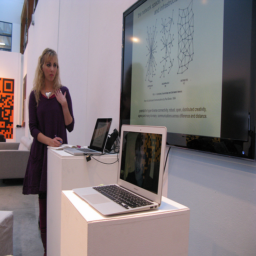

In [7]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets, bs, size, padding)
test_deprocess(datasets[d][i], size, padding)

In [8]:
sty = pre_process_style(style, tmfs, bs); sty.shape

torch.Size([8, 3, 256, 256])

In [9]:
test_hooks(TransformerNet(), dataloaders, bs, sty)
test_losses(TransformerNet(), dataloaders, sty)

shape of input_act:  [torch.Size([8, 64, 256, 256]), torch.Size([8, 256, 64, 64]), torch.Size([8, 512, 32, 32]), torch.Size([8, 512, 16, 16]), torch.Size([8, 512, 32, 32])]
shape of content_act:  [torch.Size([8, 64, 256, 256]), torch.Size([8, 256, 64, 64]), torch.Size([8, 512, 32, 32]), torch.Size([8, 512, 16, 16]), torch.Size([8, 512, 32, 32])]
shape of style_act:  [torch.Size([8, 64, 256, 256]), torch.Size([8, 256, 64, 64]), torch.Size([8, 512, 32, 32]), torch.Size([8, 512, 16, 16]), torch.Size([8, 512, 32, 32])]


In [10]:
# Van Gogh: c2s=7.2e5, c2t=1e-2, tv_weight=4, content_weight=1, style_weight=2e1, vgg=19
# Picasso: c2s=5e5, c2t=1.5e-5, tv_weight=4, content_weight=1, style_weight=1.5e1, vgg=19
# Kandinsky: c2s=4.5e5, c2t=1.5e-5, tv_weight=3, content_weight=1, style_weight=1e1, vgg=19

# Picasso: c2s=9e5

# Van Gogh Unet: c2s=5.5e5, c2t=75

In [11]:
#if calc_ratios: 
#    c2s, c2t = calc_loss_ratios(TransformerNet(), dataset_path, tmfs, size, bs, style=sty, vgg=16)
#    print(f'c2s={c2s}, c2t={c2t}')

In [12]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet()), size=size, 
                        style_weight=1,
                        content_weight=0, c2s=1.)

Min numerical gradient @lr: 6.76e-01


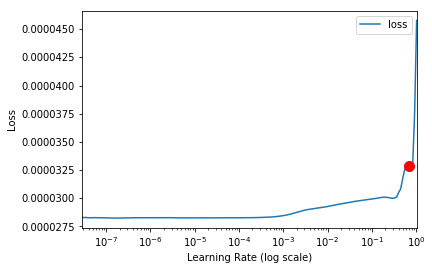

In [ ]:
fst.find_lr(sty, focus_on_style=False)

Min numerical gradient @lr: 6.76e-01


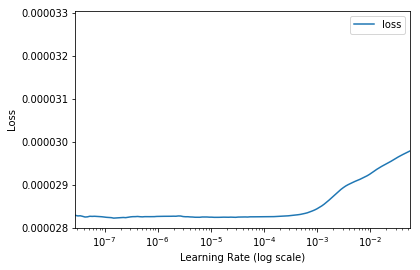

In [17]:
fst.plot_lr(skip_end=30)

In [15]:
#fst.min_grad_lr

In [30]:
# style_weight=5e5

In [14]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet(), lr=1.70e-04), size=size, 
                        style_weight=1.,
                        content_weight=0, 
                        tv_weight=None)

#fst.convs = [3]

In [15]:
fst.lr_max

0.00017

In [18]:
#fst.arch

In [19]:
#fst.convs = [1, 11, 18, 25, 20]
#fst.convs = [2, 7, 14, 21, 28]
#fst.convs = [3]

In [ ]:
fst.train(sty, num_epochs=1, focus_on_style=True)


Phase: train


(input, content, style) = torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])

phase: train, loss: 3.850319892596324e-06

Phase: valid


(input, content, style) = torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])

29m 18s



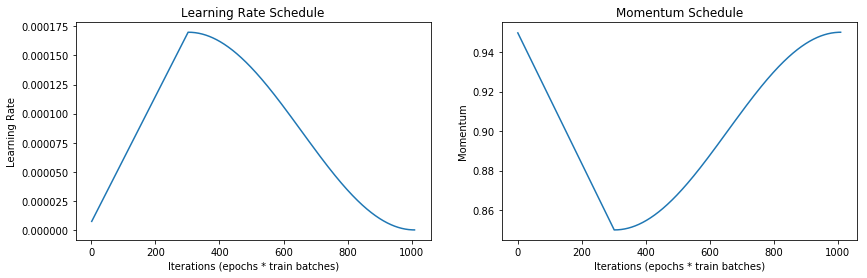

In [17]:
fst.plot_one_cycle_schedule()

In [18]:
fst.training_done

True

In [19]:
fst.get_metrics('train').head(10)

,epoch,batch,batch_size,total_loss,content_loss,style_loss,tv_loss,total,content,style
0,0,0,8,3.092279e-05,0.0,3.092279e-05,0,3.86535e-06,0,3.86535e-06
1,0,1,8,3.084342e-05,0.0,3.084342e-05,0,3.85543e-06,0,3.85543e-06
2,0,2,8,3.1027674e-05,0.0,3.1027674e-05,0,3.87846e-06,0,3.87846e-06
3,0,3,8,3.0880885e-05,0.0,3.0880885e-05,0,3.86011e-06,0,3.86011e-06
4,0,4,8,3.0755775e-05,0.0,3.0755775e-05,0,3.84447e-06,0,3.84447e-06
5,0,5,8,3.080462e-05,0.0,3.080462e-05,0,3.85058e-06,0,3.85058e-06
6,0,6,8,3.082116e-05,0.0,3.082116e-05,0,3.85265e-06,0,3.85265e-06
7,0,7,8,3.0729505e-05,0.0,3.0729505e-05,0,3.84119e-06,0,3.84119e-06
8,0,8,8,3.0526822e-05,0.0,3.0526822e-05,0,3.81585e-06,0,3.81585e-06
9,0,9,8,3.0821357e-05,0.0,3.0821357e-05,0,3.85267e-06,0,3.85267e-06


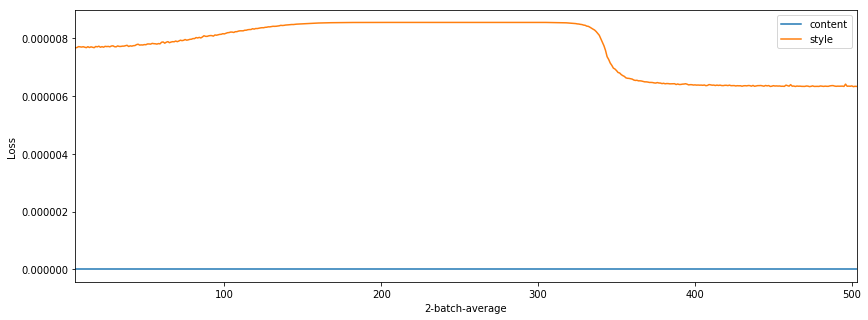

In [21]:
fst.plot_losses('train', group=2, skip=5)

In [25]:
#fst.plot_samples('train')

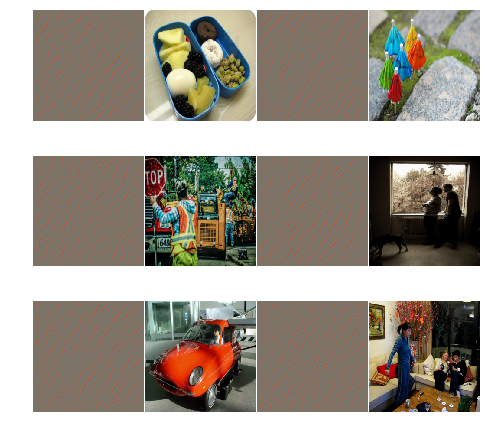

In [22]:
fst.plot_samples('valid')

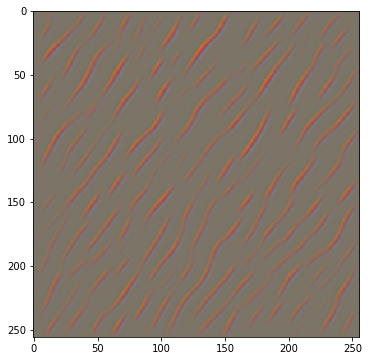

In [23]:
ds = fst.dl['valid'].dataset
idx = random.sample(range(len(ds)), 1)[0]
denorm = DeProcess(imagenet_stats, fst.size, fst.p)
out = denorm(fst.run_st(ds[idx][0]))
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(out); 

In [28]:
#fst.save_model()